In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import glob
from tqdm import tqdm
from functools import partial
import ot
from matplotlib import pyplot as plt
from collections import defaultdict
import torch, torch.nn as nn
from torch.distributions import Normal
from easydict import EasyDict as edict

In [3]:
# from iterative_sir.toy_examples_utils.toy_examples_utils import prepare_swissroll_data
from iterative_sir.toy_examples_utils.gan_fc_models import (
    Generator_fc, 
    Discriminator_fc,
    )
from iterative_sir.sampling_utils.visualization import (
                           sample_fake_data,
                           plot_discriminator_2d,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           plot_chain_metrics)
from iterative_sir.sampling_utils.ebm_sampling import (
                          langevin_sampling,
                          gan_energy,
                          IndependentNormal)

from iterative_sir.sampling_utils.metrics import Evolution



# import numpy as np
# import random
# from easydict import EasyDict as edict
# from matplotlib import pyplot as plt
# import torch, torch.nn as nn

# from iterative_sir.toy_examples_utils.gan_fc_models import (Generator_fc, 
#                            Discriminator_fc)

# from iterative_sir.sampling_utils.distributions import (
#                            GaussianMixture, 
#                            IndependentNormal)

# from iterative_sir.toy_examples_utils.params_25gaussians_wasserstein import (sigma,
#                                 random_seed,
#                                 train_dataset_size,
#                                 n_dim,
#                                 n_layers_d,
#                                 n_layers_g,
#                                 n_hid_d,
#                                 n_hid_g,
#                                 n_out,
#                                 device)


In [4]:
class Discriminator_fc(nn.Module):
    def __init__(self,
                 n_in = 2,
                 n_layers = 4,
                 n_hid = 100, 
                 non_linear = nn.ReLU(),
                 scale=1.,
                 device = 'cpu'):
        super(Discriminator_fc, self).__init__()
        self.non_linear = non_linear
        self.device = device
        self.n_hid = n_hid
        self.n_in = n_in
        self.scale = scale
        layers = [nn.Linear(self.n_in, self.n_hid), non_linear]
        for i in range(n_layers - 1):
            layers.extend([nn.Linear(n_hid, n_hid), non_linear])
        layers.append(nn.Linear(n_hid, 1))

        self.calib_layer = None

        self.layers = nn.Sequential(*layers)
      
    def forward(self, z):
        z = z / self.scale**2.
        z = self.layers.forward(z)
        if self.calib_layer is not None:
            z = self.calib_layer(z)
        return z

In [56]:
D.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 1.8936e-01, -4.4166e-01],
                      [-3.0581e-01,  3.1962e-01],
                      [ 2.6588e-01,  2.9564e-01],
                      [-2.2072e-01, -1.0617e-01],
                      [-2.4420e-01,  2.0778e-01],
                      [-2.9207e-01, -2.5469e-01],
                      [-1.4416e-01, -7.2978e-02],
                      [ 5.3835e-02, -4.7963e-01],
                      [ 3.6328e-01, -3.5329e-01],
                      [ 2.4915e-02, -2.3104e-01],
                      [-3.5777e-01,  3.2897e-01],
                      [-1.3668e-01, -4.9612e-01],
                      [ 9.8228e-02,  1.0854e-03],
                      [-3.5921e-01,  1.2615e-01],
                      [-2.2254e-01,  2.7612e-01],
                      [-1.8221e-01,  7.2743e-02],
                      [ 4.9259e-01,  5.4218e-03],
                      [ 1.1165e-01,  3.9565e-01],
                      [ 6.6196e-03,  4.6916e-02],
                 

In [54]:
D.layers[0].weight.data = D.layers[0].weight.data / scale**2

In [55]:
D.layers[0].weight

Parameter containing:
tensor([[ 1.8936e-01, -4.4166e-01],
        [-3.0581e-01,  3.1962e-01],
        [ 2.6588e-01,  2.9564e-01],
        [-2.2072e-01, -1.0617e-01],
        [-2.4420e-01,  2.0778e-01],
        [-2.9207e-01, -2.5469e-01],
        [-1.4416e-01, -7.2978e-02],
        [ 5.3835e-02, -4.7963e-01],
        [ 3.6328e-01, -3.5329e-01],
        [ 2.4915e-02, -2.3104e-01],
        [-3.5777e-01,  3.2897e-01],
        [-1.3668e-01, -4.9612e-01],
        [ 9.8228e-02,  1.0854e-03],
        [-3.5921e-01,  1.2615e-01],
        [-2.2254e-01,  2.7612e-01],
        [-1.8221e-01,  7.2743e-02],
        [ 4.9259e-01,  5.4218e-03],
        [ 1.1165e-01,  3.9565e-01],
        [ 6.6196e-03,  4.6916e-02],
        [ 6.5648e-02, -1.8553e-01],
        [ 3.8837e-01,  2.9408e-04],
        [-1.5457e-01, -3.8166e-01],
        [-1.1856e-01,  6.6485e-02],
        [-3.5386e-01, -1.6092e-01],
        [-1.0013e-01,  4.7054e-03],
        [ 2.8860e-02, -3.1344e-01],
        [-1.2202e-01,  3.6494e-01],
      

In [ ]:
torch.save(D.state_dict(), '../dump/2d_ring/2022_01_14-15_27_39_None/models/400_discriminator_scaled.pth')

In [5]:
import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

In [6]:
from pathlib import Path

figpath = Path('../figs')

assert figpath.exists()

In [7]:
import itertools

def prepare_2d_ring_data(batch_size=500,
                        sigma=0.01,
                        rad=2,
                        random_seed=42):
    dataset = []
    rad = 2
    for i in range(batch_size//8):
        for j in range(8):
            phi = 2 * np.pi * (j / 8.)
            x = rad * np.cos(phi)
            y = rad * np.sin(phi)
            point = np.random.randn(2)*sigma
            point[0] += x
            point[1] += y
            dataset.append(point)
    dataset = np.array(dataset, dtype=np.float32)

    means = np.array([
        [
            rad * np.cos(2 * np.pi * (j / 8.)), 
            rad * np.sin(2 * np.pi * (j / 8.))
        ] for j in range(8)])

    return dataset, means

In [44]:
from sklearn.preprocessing import StandardScaler

random_seed = 42
train_dataset_size = 5000

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_2d_ring_data(train_dataset_size,
                                         0.02,#sigma / 2., 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
scale = scaler.scale_[0]
scaler = None

In [42]:
scale

1.414196804223976

In [9]:
device = 'cpu'

G = Generator_fc(n_dim=256, #n_dim, 
                 n_layers=2, #n_layers_g,
                 n_hid=128, #n_hid_g,
                 n_out=2, #n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=2, #n_dim, 
                     n_layers=2, #n_layers_d,
                     n_hid=128, #n_hid_d,
                     non_linear=nn.ReLU(),
                     scale=scale,
                     device=device)

In [51]:
dics_path

PosixPath('../dump/2d_ring/2022_01_14-15_27_39_None/models/400_discriminator.pth')

In [50]:
models_2d_path = Path(sorted(Path('../dump/2d_ring').glob('*'))[-1], 'models') #/models/models_100gaussians'

dics_path = sorted(Path(models_2d_path).glob('350_discriminator.pth'))[0]#[-6]
gen_path = sorted(Path(models_2d_path).glob('350_generator.pth'))[0]#[-6]

train_step = 400
dics_path = sorted(Path(models_2d_path).glob(f'{train_step}_discriminator.pth'))[0]#[-6]
gen_path = sorted(Path(models_2d_path).glob(f'{train_step}_generator.pth'))[0]#[-6]

G.load_state_dict(torch.load(gen_path, map_location=device))
D.load_state_dict(torch.load(dics_path, map_location=device))

G = G.to(device)
D = D.to(device)
G.eval()
D.eval()
G.z_dim = G.n_dim

In [21]:
n_dim = G.n_dim
n_out = 2
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normalize_to_0_1 = True 
log_prob = True

proposal_args = edict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(dim=n_dim, **proposal_args)

target = partial(gan_energy, 
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [22]:
evols = dict()

In [23]:
batch_size = 1000 #25 #5000
n_steps = 800
every = 200

In [24]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

grad_step = 1e-1 #3e-3
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = langevin_sampling(target,
                               proposal,  
                               batch_size=batch_size,
                               n = batch_size,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps)

n_chunks = len(zs[0]) // every
#
zs_gen = zs #.reshape(batch_size, n_chunks, -1, zs.shape[-1])

Xs_gen = G(torch.FloatTensor(zs_gen).to(device)).detach().cpu().numpy()[0].transpose(1, 0, 2)
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

# evol = defaultdict(list)
# for X_gen in Xs_gen:
#     evolution = Evolution(target_sample) #,
#                      # target_log_prob=target)
#     for chunk in X_gen:
#         evolution.invoke(torch.FloatTensor(chunk))
#     evol_ = evolution.as_dict()
#     for k, v in evol_.items():
#         evol[k].append(v)

# for k, v in evol.items():
#     evol[k] = (np.mean(np.array(v), 0), np.std(np.array(v), 0, ddof=1) / np.sqrt(batch_size))
# evols['ULA'] = evol

100%|██████████| 1/1 [00:08<00:00,  8.39s/it]


In [25]:
Xs_gen.shape

(1000, 801, 2)

In [26]:
# Xs_batch = Xs_gen.reshape(batch_size, -1, 2)

In [27]:
#plot_chain_metrics(evols)

In [28]:
import scipy.stats

mesh = np.meshgrid(np.linspace(-2.2, 2.2, 100), np.linspace(-2.2, 2.2, 100))
mesh_np = np.stack(mesh, -1).reshape(-1, 2)

kde = scipy.stats.gaussian_kde(X_train.transpose(1, 0))
vals = kde(mesh_np.transpose(1, 0))
vals_grid = vals.reshape(100, 100)
mesh = mesh_np.reshape(100, 100, 2)

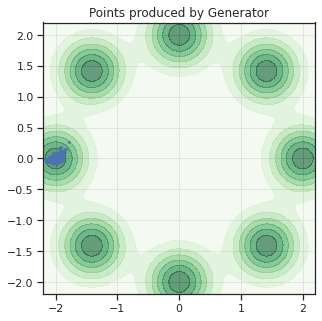

In [29]:
zs = proposal.sample((5000,))
xs_normalized = G(zs).detach().numpy()
xs = xs_normalized #scaler.inverse_transform(xs_normalized)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.contourf(mesh[..., 0], mesh[..., 1], vals_grid, alpha=0.6, cmap='Greens')
ax.scatter(xs[:, 0], xs[:, 1], s=3)
ax.set_aspect('equal')
plt.xlim(-2.2, 2.2)
plt.ylim(-2.2, 2.2)
plt.grid()
plt.title('Points produced by Generator')
plt.savefig(Path('../figs/2d_grid', f'gen_{train_step}.png'))

In [36]:
G(torch.ones(10, G.z_dim) * 0)

tensor([[-1.6225,  0.0496],
        [-1.6225,  0.0496],
        [-1.6225,  0.0496],
        [-1.6225,  0.0496],
        [-1.6225,  0.0496],
        [-1.6225,  0.0496],
        [-1.6225,  0.0496],
        [-1.6225,  0.0496],
        [-1.6225,  0.0496],
        [-1.6225,  0.0496]], grad_fn=<AddmmBackward>)

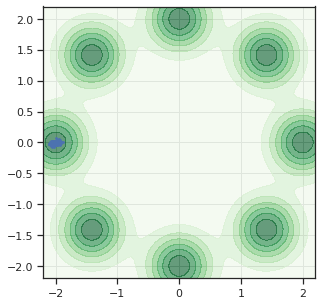

In [ ]:
# zs = proposal.sample((5000,))
# xs_normalized = G(zs).detach().numpy()
# xs = xs_normalized #scaler.inverse_transform(xs_normalized)
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

def init_animation():
    global scat
    ax.scatter(Xs_gen[:, 0, 0], Xs_gen[:, 0, 1], s=3)

def animate(i):
    ax.clear()
    ax.contourf(mesh[..., 0], mesh[..., 1], vals_grid, alpha=0.6, cmap='Greens')
    ax.set_aspect('equal')
    plt.xlim(-2.2, 2.2)
    plt.ylim(-2.2, 2.2)
    plt.grid()
    ax.scatter(Xs_gen[:, 10*i, 0], Xs_gen[:, 10*i, 1], s=3)
    return

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.contourf(mesh[..., 0], mesh[..., 1], vals_grid, alpha=0.6, cmap='Greens')
ax.set_aspect('equal')
plt.xlim(-2.2, 2.2)
plt.ylim(-2.2, 2.2)
plt.grid()
plt.title('Points produced with Langevin')

ani = matplotlib.animation.FuncAnimation(fig, animate, init_func=init_animation, frames=80)
ani.save(f'../figs/2d_grid/ula_{grad_step}_{train_step}.gif', writer='imagemagick', fps=30)

# plt.savefig(Path('../figs/2d_grid', 'ula_0.01.png'))